# Conditional GAN으로 생성 컨트롤하기

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ]),
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

In [22]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [5]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images= G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차를 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산 (무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

c:\users\sang jun\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


이폭 [0/300] d_loss:0.0942 g_loss: 7.2400 D(x):0.97 D(G(z)):0.04
이폭 [1/300] d_loss:0.2845 g_loss: 4.6413 D(x):0.91 D(G(z)):0.10
이폭 [2/300] d_loss:0.1733 g_loss: 6.2835 D(x):0.92 D(G(z)):0.04
이폭 [3/300] d_loss:0.5073 g_loss: 3.1286 D(x):0.85 D(G(z)):0.16
이폭 [4/300] d_loss:0.4926 g_loss: 3.2798 D(x):0.80 D(G(z)):0.06
이폭 [5/300] d_loss:0.4352 g_loss: 3.0679 D(x):0.88 D(G(z)):0.17
이폭 [6/300] d_loss:0.7005 g_loss: 2.2023 D(x):0.86 D(G(z)):0.28
이폭 [7/300] d_loss:0.5905 g_loss: 2.6305 D(x):0.79 D(G(z)):0.16
이폭 [8/300] d_loss:0.9798 g_loss: 1.7161 D(x):0.67 D(G(z)):0.29
이폭 [9/300] d_loss:0.6772 g_loss: 1.9845 D(x):0.81 D(G(z)):0.27
이폭 [10/300] d_loss:0.6707 g_loss: 1.8732 D(x):0.72 D(G(z)):0.18
이폭 [11/300] d_loss:0.6086 g_loss: 2.3328 D(x):0.85 D(G(z)):0.23
이폭 [12/300] d_loss:0.5685 g_loss: 2.6158 D(x):0.81 D(G(z)):0.18
이폭 [13/300] d_loss:0.9143 g_loss: 1.6641 D(x):0.73 D(G(z)):0.30
이폭 [14/300] d_loss:0.7589 g_loss: 2.1701 D(x):0.75 D(G(z)):0.23
이폭 [15/300] d_loss:0.8528 g_loss: 1.8987 D(x):0.71

이폭 [127/300] d_loss:1.3596 g_loss: 0.7163 D(x):0.56 D(G(z)):0.50
이폭 [128/300] d_loss:1.4154 g_loss: 0.9942 D(x):0.58 D(G(z)):0.46
이폭 [129/300] d_loss:1.1835 g_loss: 0.9443 D(x):0.59 D(G(z)):0.42
이폭 [130/300] d_loss:1.4422 g_loss: 0.8847 D(x):0.53 D(G(z)):0.48
이폭 [131/300] d_loss:1.2219 g_loss: 1.1204 D(x):0.59 D(G(z)):0.39
이폭 [132/300] d_loss:1.0378 g_loss: 1.0889 D(x):0.62 D(G(z)):0.37
이폭 [133/300] d_loss:1.3060 g_loss: 1.1727 D(x):0.59 D(G(z)):0.42
이폭 [134/300] d_loss:1.2490 g_loss: 1.1395 D(x):0.60 D(G(z)):0.41
이폭 [135/300] d_loss:1.1589 g_loss: 1.1547 D(x):0.59 D(G(z)):0.38
이폭 [136/300] d_loss:1.2921 g_loss: 1.0717 D(x):0.58 D(G(z)):0.44
이폭 [137/300] d_loss:1.3051 g_loss: 0.9265 D(x):0.54 D(G(z)):0.44
이폭 [138/300] d_loss:1.2024 g_loss: 0.8991 D(x):0.61 D(G(z)):0.44
이폭 [139/300] d_loss:1.2525 g_loss: 1.0788 D(x):0.57 D(G(z)):0.42
이폭 [140/300] d_loss:1.3074 g_loss: 0.9699 D(x):0.58 D(G(z)):0.47
이폭 [141/300] d_loss:1.2845 g_loss: 0.9274 D(x):0.55 D(G(z)):0.43
이폭 [142/300] d_loss:1.367

이폭 [253/300] d_loss:1.3285 g_loss: 0.8489 D(x):0.53 D(G(z)):0.46
이폭 [254/300] d_loss:1.4039 g_loss: 1.0957 D(x):0.57 D(G(z)):0.46
이폭 [255/300] d_loss:1.1990 g_loss: 0.8701 D(x):0.58 D(G(z)):0.43
이폭 [256/300] d_loss:1.3115 g_loss: 0.8829 D(x):0.52 D(G(z)):0.45
이폭 [257/300] d_loss:1.2943 g_loss: 0.8784 D(x):0.56 D(G(z)):0.44
이폭 [258/300] d_loss:1.1165 g_loss: 1.1310 D(x):0.58 D(G(z)):0.36
이폭 [259/300] d_loss:1.2794 g_loss: 0.8752 D(x):0.53 D(G(z)):0.42
이폭 [260/300] d_loss:1.3615 g_loss: 0.8832 D(x):0.57 D(G(z)):0.47
이폭 [261/300] d_loss:1.1822 g_loss: 1.4151 D(x):0.58 D(G(z)):0.34
이폭 [262/300] d_loss:1.2598 g_loss: 0.9599 D(x):0.57 D(G(z)):0.43
이폭 [263/300] d_loss:1.1663 g_loss: 0.9803 D(x):0.59 D(G(z)):0.43
이폭 [264/300] d_loss:1.1430 g_loss: 1.3078 D(x):0.59 D(G(z)):0.34
이폭 [265/300] d_loss:1.3990 g_loss: 0.8755 D(x):0.58 D(G(z)):0.48
이폭 [266/300] d_loss:1.2499 g_loss: 0.9168 D(x):0.58 D(G(z)):0.44
이폭 [267/300] d_loss:1.1877 g_loss: 0.8707 D(x):0.60 D(G(z)):0.44
이폭 [268/300] d_loss:1.310

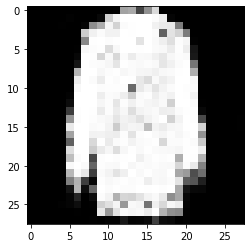

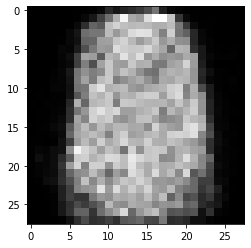

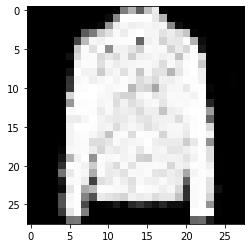

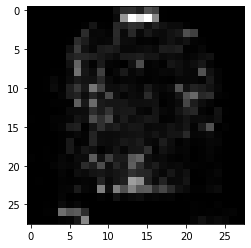

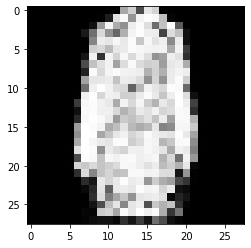

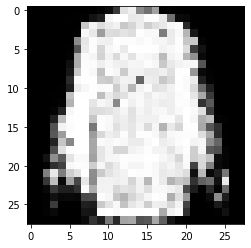

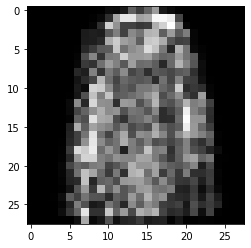

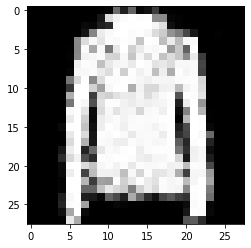

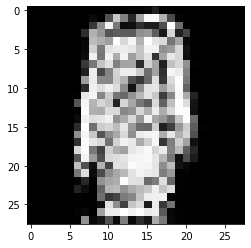

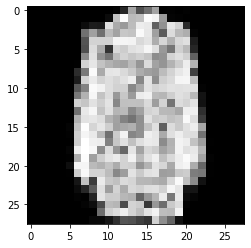

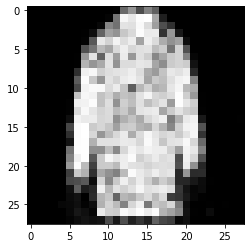

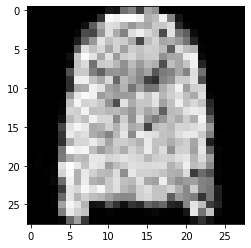

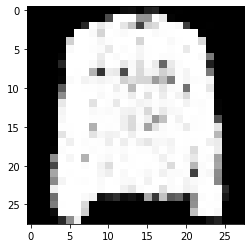

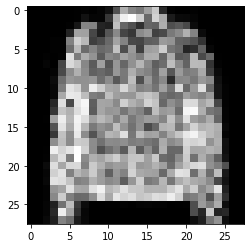

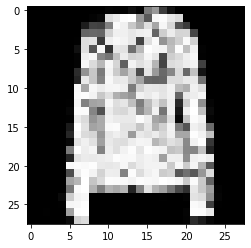

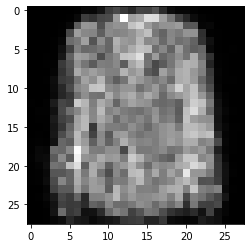

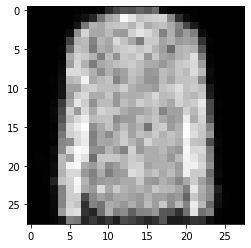

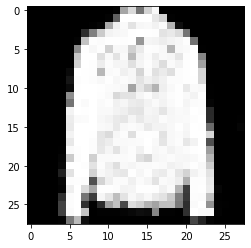

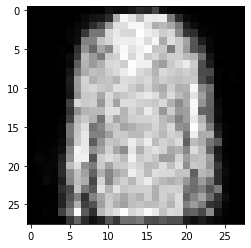

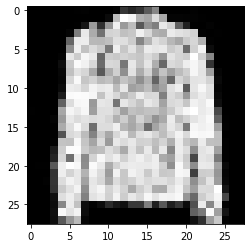

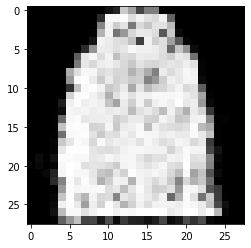

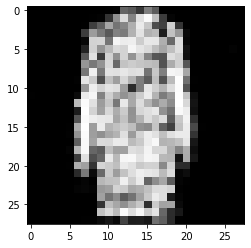

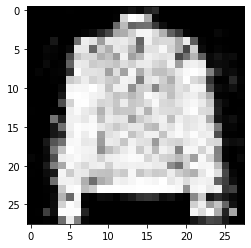

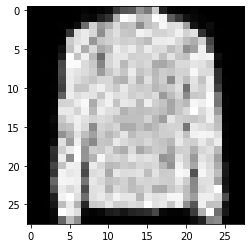

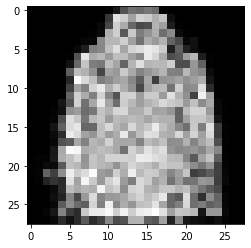

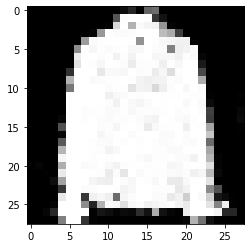

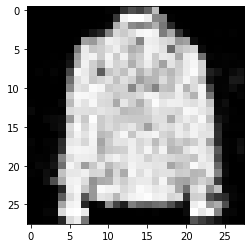

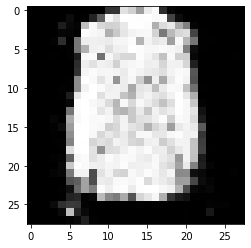

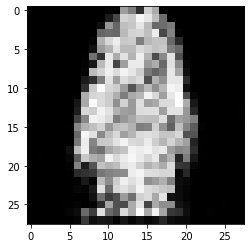

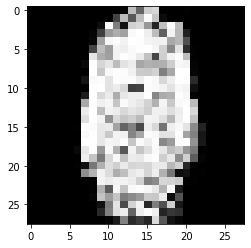

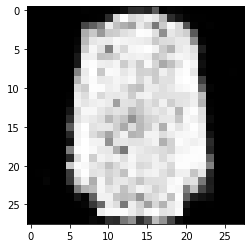

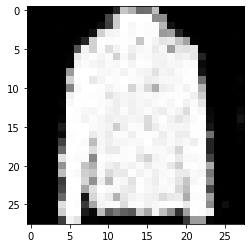

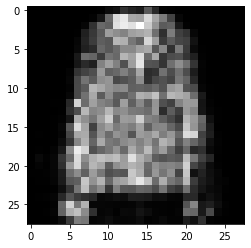

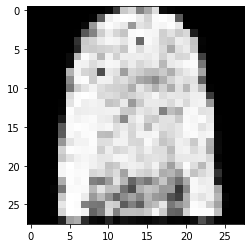

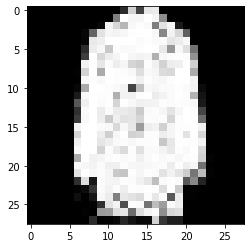

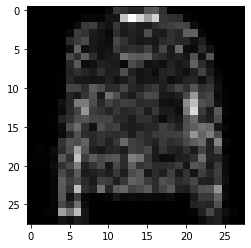

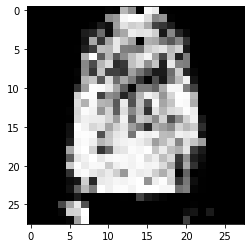

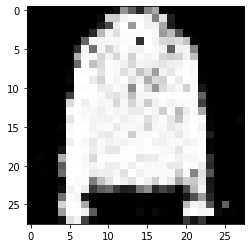

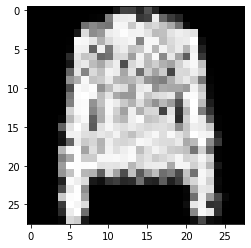

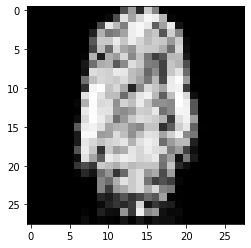

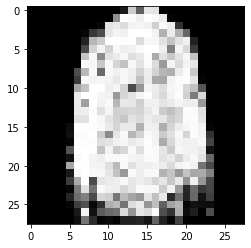

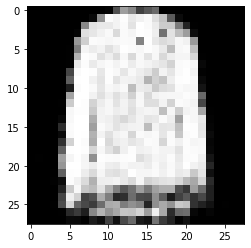

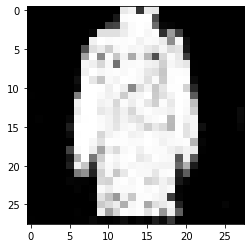

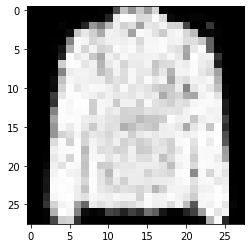

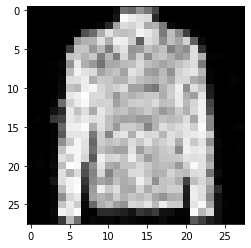

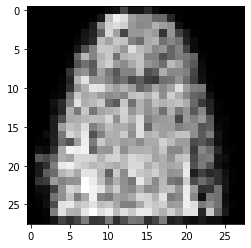

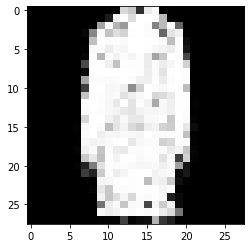

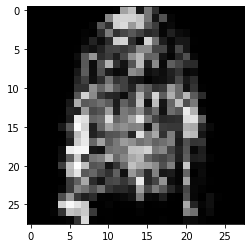

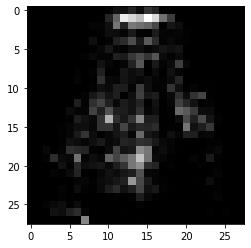

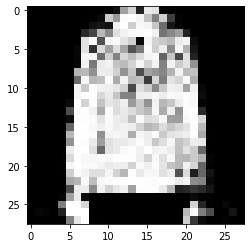

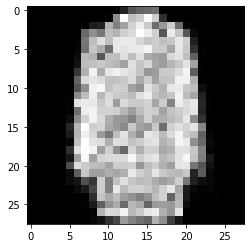

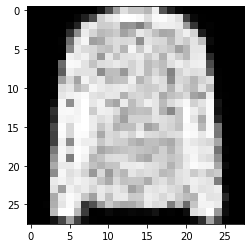

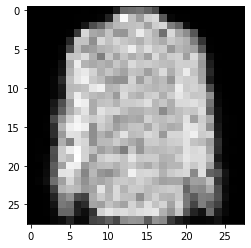

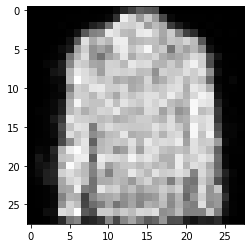

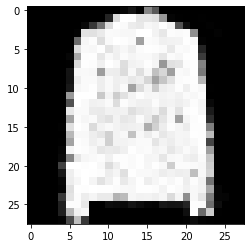

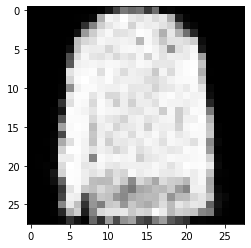

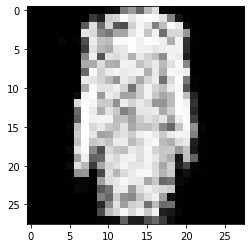

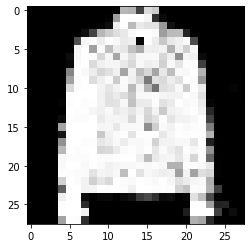

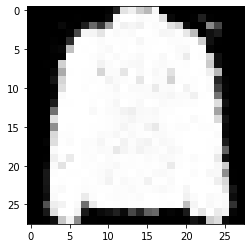

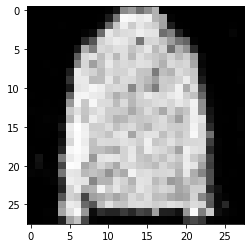

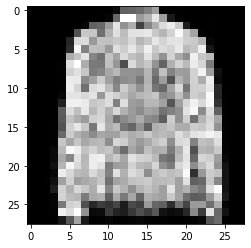

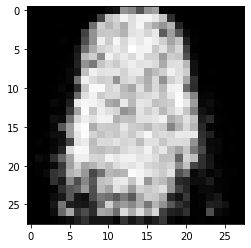

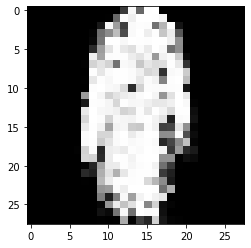

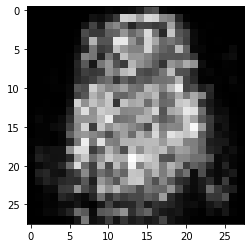

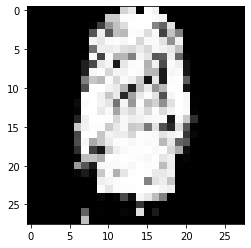

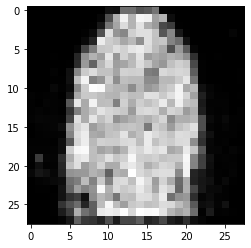

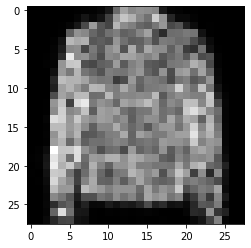

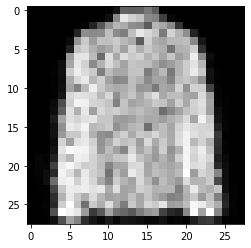

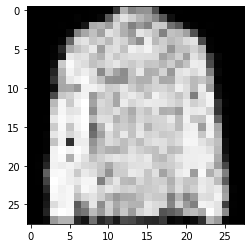

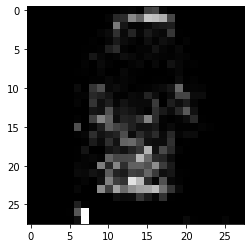

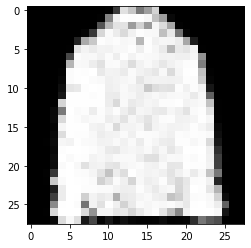

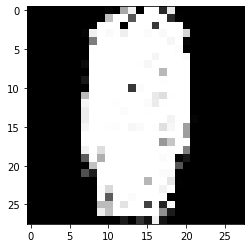

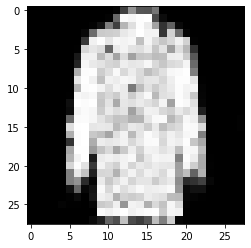

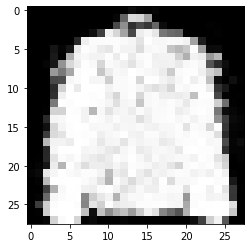

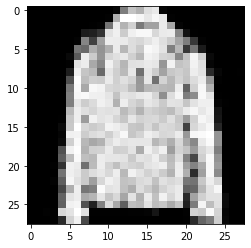

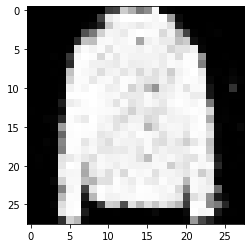

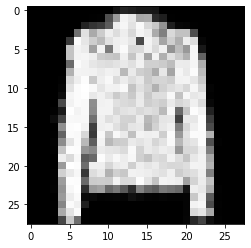

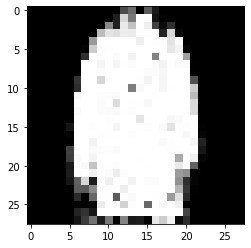

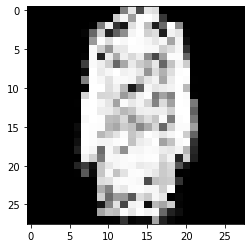

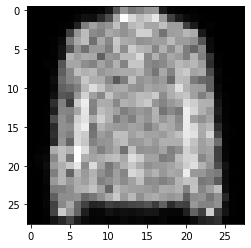

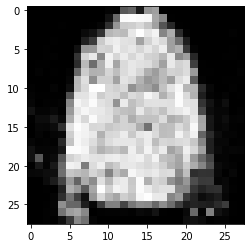

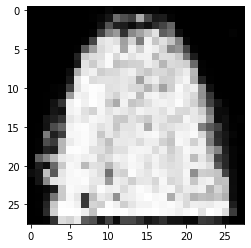

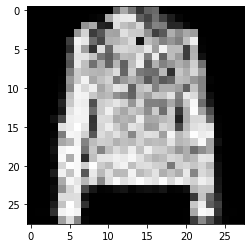

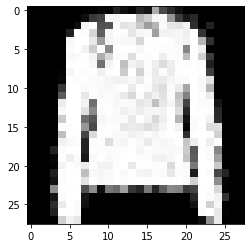

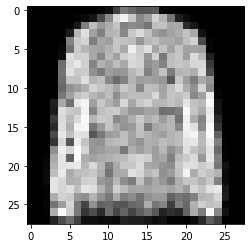

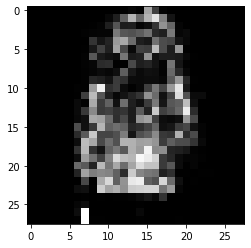

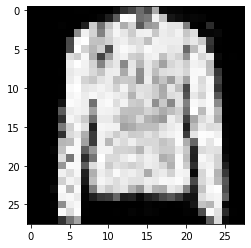

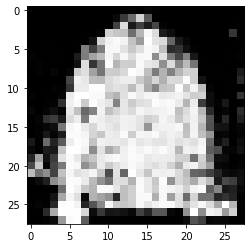

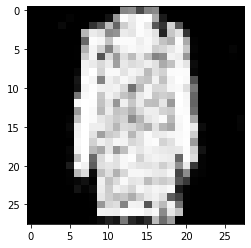

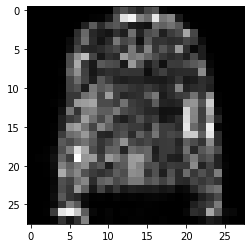

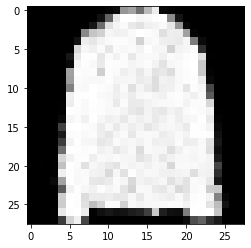

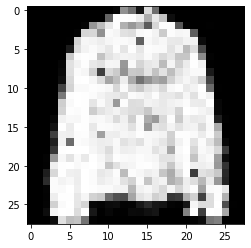

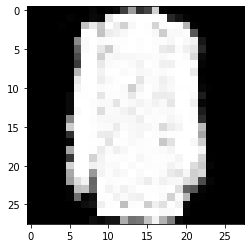

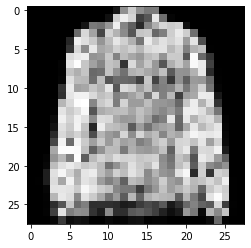

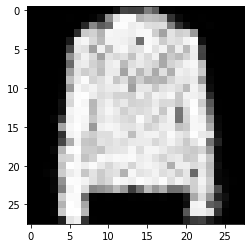

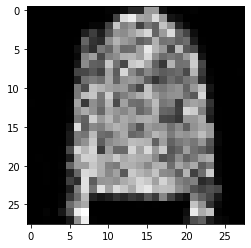

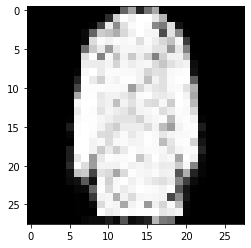

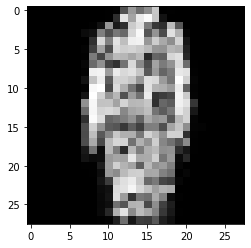

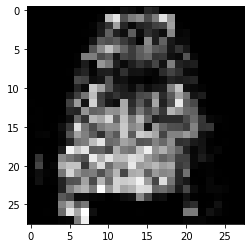

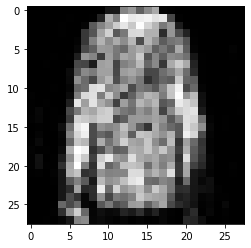

In [35]:
for i in range(100):
    label = torch.tensor([4]).to(DEVICE)
    class_label = label.to(DEVICE)
    z = torch.randn(1, 100).to(DEVICE)
    fake_images = G(z, class_label)
    fake_images = np.reshape(fake_images.cpu().data.numpy()[0],(28, 28))
    plt.imshow(fake_images, cmap = 'gray')
    plt.show()

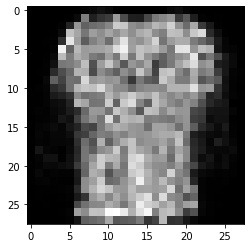

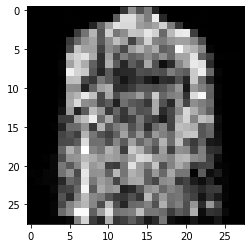

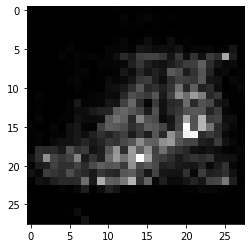

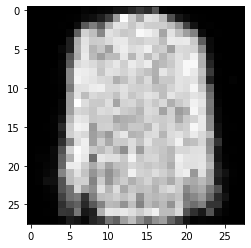

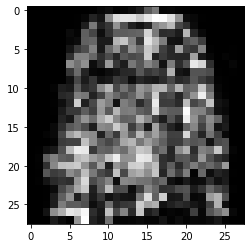

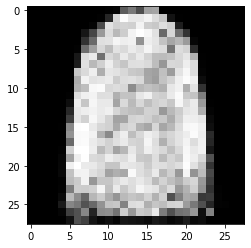

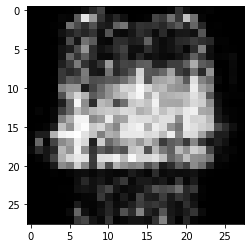

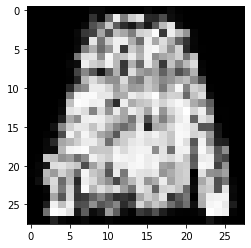

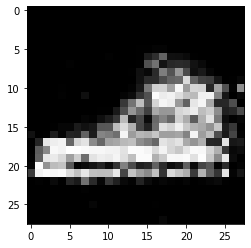

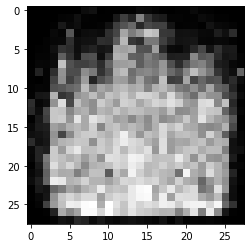

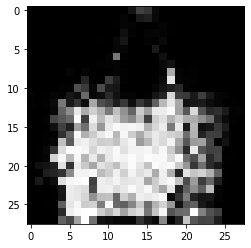

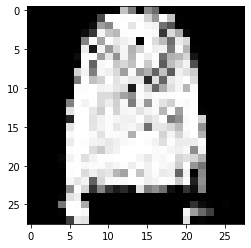

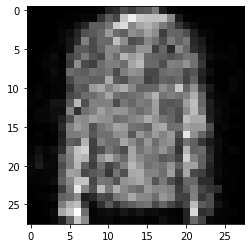

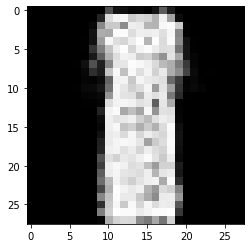

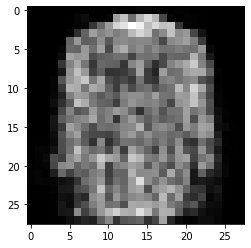

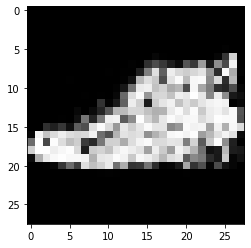

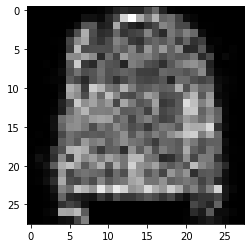

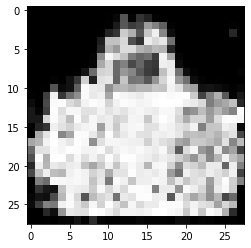

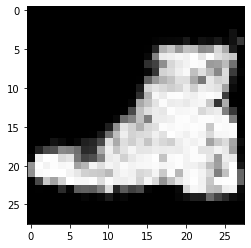

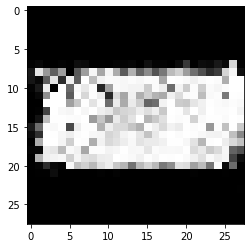

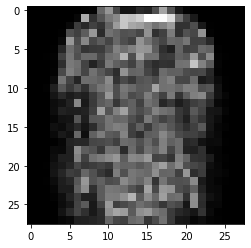

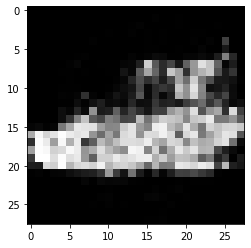

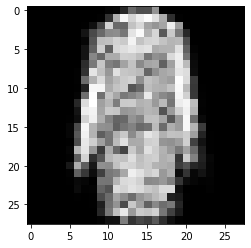

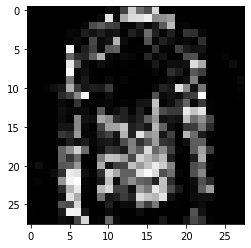

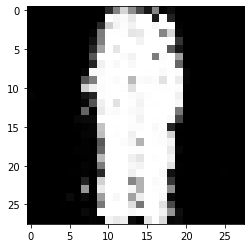

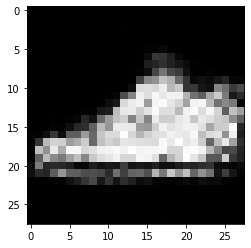

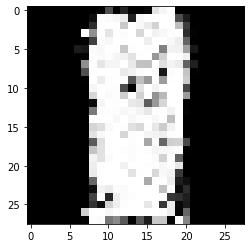

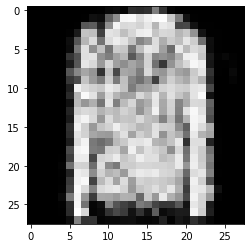

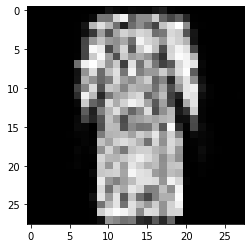

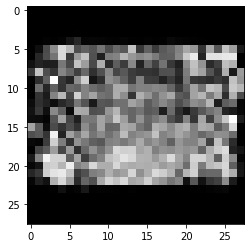

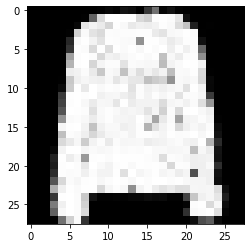

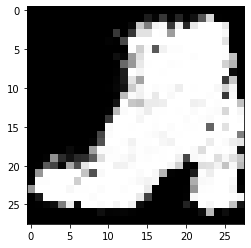

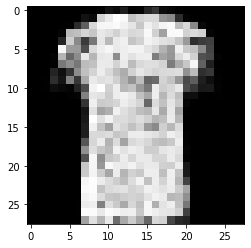

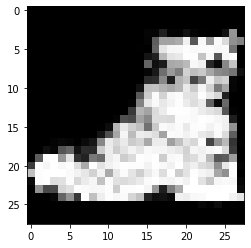

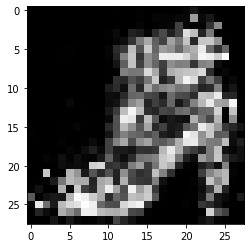

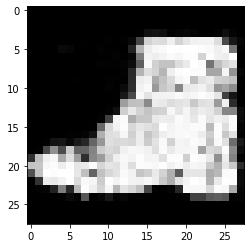

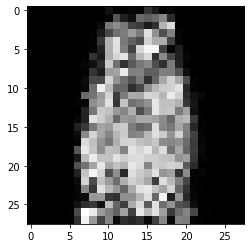

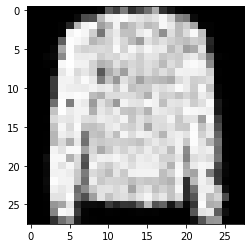

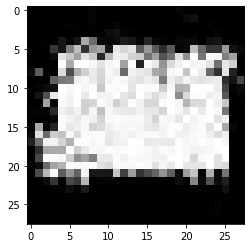

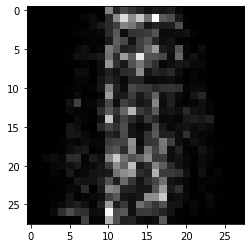

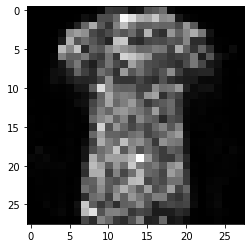

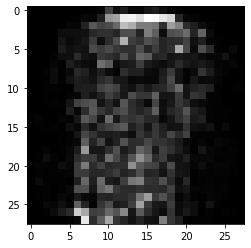

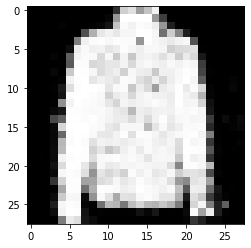

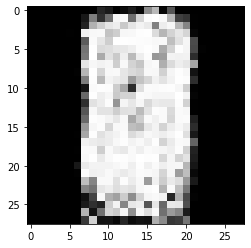

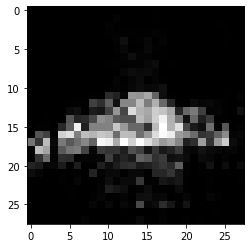

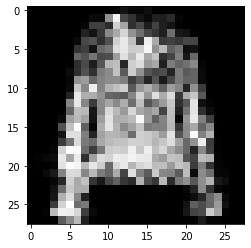

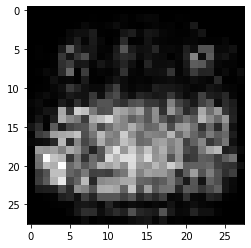

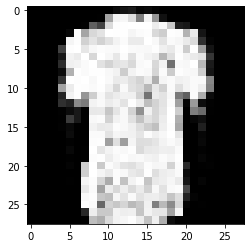

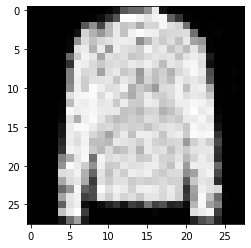

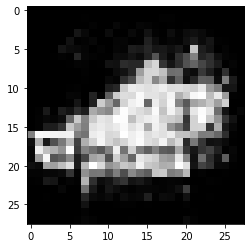

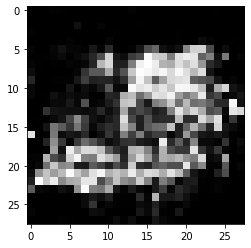

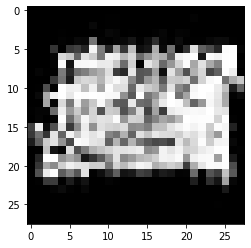

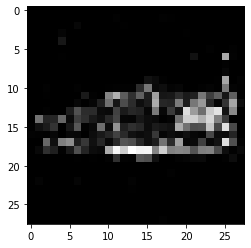

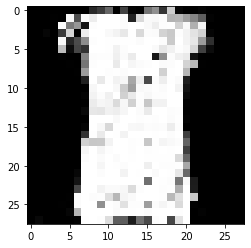

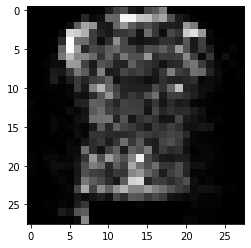

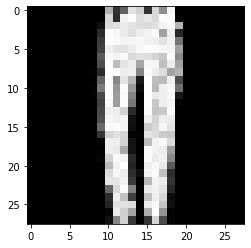

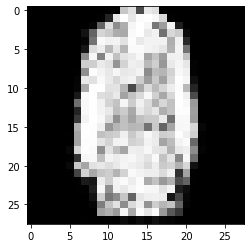

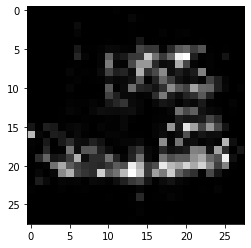

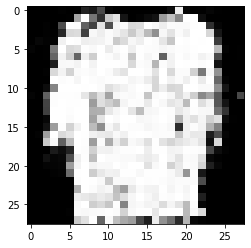

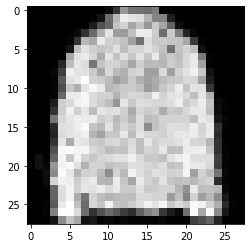

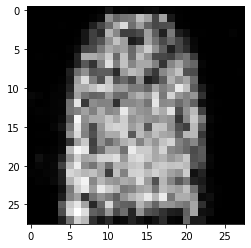

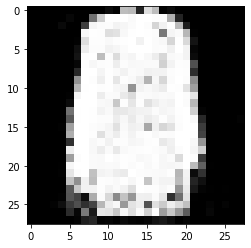

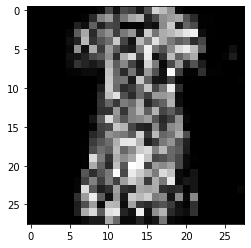

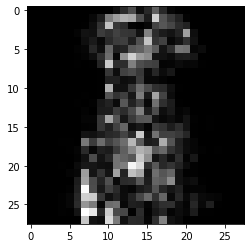

In [47]:
# 생성자가 만든 이미지 시각화하기
z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
g_label = torch.randint(0, 10, (BATCH_SIZE, )).squeeze().to(DEVICE)
fake_images = G(z, g_label)
for i in range(64):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()